<a href="https://colab.research.google.com/github/ucbnlp24/hws4nlp24/blob/main/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Large Language Models & Prompting

### Due Date: March 8th, 2024 (11:59pm)

## Total Points: 100 points
- *Warning*: Start this assignment early as it is dependent on the OpenAI API!
- **Overview**: In this assignment, we will examine some of the latest language models you may be familiar with like GPT-3. We'll cover:

  - Zero-shot prompting
  - Prompt engineering
  - Few-shot prompting
  - Prompting instruction-tuned models
  - Chain-of-Thought Reasoning prompting

- **OpenAI Account Setup**: You will need an OpenAI account and API key, you can [sign up here](https://platform.openai.com/signup?launch) (click on `API`) and learn [how to make an API key here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). The OpenAI API is paid, however,  this homework will stay well under the free $5 credit given to each account. Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, avoid running cells over and over again after you've completed an exercise.

- **Grading**: To complete the homework assignment, you should implement anything marked with `#TODO`
  - **NOTE #1**: For this assignment you will be creating your own unit tests for the prompts you generate. For each 'Code' section below you are required to write **3 unit tests** per prompt and submit the prompt, unit test, and output (more details in Submissions section) in the report.
  - **NOTE #2**: A boilerplate unit test function is provided below in the setup section, feel free to modify or come up with your own as long as you include the **expected** answer and the **response** from the OpenAI API in the cell output and report.
  - **NOTE #3**: Points will be deducted if you go over the word limit for questions with a word limit.
  - **NOTE #4**: Have fun with this homework! It's meant to be more exploratory and for you to gain exposure to current LLM trends.

- **Deliverables:** This assignment has several deliverables:
  - Code (this notebook) *(Manually Graded)*
    - Section 1: 1.1, 1.2, 1.3, 1.4, 1.5, 1.6
    - Section 3: 3.1, 3.2
    - Section 4: 4.1, 4.2
    - Section 5: 5.1, 5.2
  - Write Up (report.pdf) *(Manually Graded)*
    - All Sections


## Recommended Readings
- [Language Models are Few-Shot Learners](https://arxiv.org/pdf/2005.14165.pdf). Tom B. Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared Kaplan, ...others. ArXiV 2020.
- [Pre-train, Prompt, and Predict: A Systematic Survey of Prompting Methods in Natural Language Processing](https://arxiv.org/pdf/2107.13586.pdf). Pengfei Liu, Weizhe Yuan, Jinlan Fu, Zhengbao Jiang, Hiroaki Hayashi, Graham Neubig. ACM Computing Surveys 2021.
- [Best practices for prompt engineering with OpenAI API](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api). Jessica Shieh. OpenAI 2023.
- [Training language models to follow instructions with human feedback](https://arxiv.org/pdf/2203.02155.pdf). Long Ouyang, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L. Wainwright, ...others. ArXiV 2020.
- [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/pdf/2201.11903.pdf). Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, brian ichter, Fei Xia, Ed H. Chi, Quoc V Le, Denny Zhou. NeurIPS 2022.

## To get started, **make a copy** of this colab notebook into your google drive!

## Setup: Dataset / Packages
- **Run the following cells and enter your OpenAI API Key!**
- The models we are using are not the best models OpenAI has to offer (for cost reasons), therefore, the output you get from prompting ChatGPT for example may not match the output from the API.
- We will be using `babbage-002` and `gpt-3.5-turbo-instruct` for this assignment
  - Babbage: can understand and generate natural language but can't follow instructions
  - GPT 3.5 Turbo Instruct: can understand and generate natural language as well as follow explicit instructions (more on this in section 4)

In [ ]:
%%capture
!pip install openai datasets

import openai
from openai import OpenAI
from time import sleep
from datasets import load_dataset

IMDB_DATASET = load_dataset("imdb", split='train').shuffle(42)[0:50]
IMDB_DATASET_X = IMDB_DATASET['text']
IMDB_DATASET_Y = IMDB_DATASET['label']
del IMDB_DATASET


# TODO - Start
OPENAI_API_KEY = "REDACTED"
# TODO - End

cache = {}
def run_gpt3(prompt, return_first_line = True, instruction_tuned = False):
    # Return the response from the cache if we have already run this
    cache_key = (prompt, return_first_line, instruction_tuned)
    if cache_key in cache:
        return cache[cache_key]
    client = OpenAI(
      api_key=OPENAI_API_KEY,
    )
    # Set the API Key


    # Select the model
    if instruction_tuned:
        model = "gpt-3.5-turbo-instruct"
    else:
        model = "babbage-002"

    # Send the prompt to GPT-3
    for i in range(0,60,6):
        try:
            response = client.completions.create(
                model=model,
                prompt=prompt,
                temperature=0,
                max_tokens=100,
                top_p=1,
                frequency_penalty=0.0,
                presence_penalty=0.0,
            )
            response = dict(response)['choices'][0]
            response = dict(response)['text'].strip()
            break
        except Exception as e:
            print(e)
            sleep(i)

    # Parse the response
    if return_first_line:
        final_response = response.split('\n')[0]
    else:
        final_response = response

    # Cache and return the response
    cache[cache_key] = final_response
    return final_response

## Boilerplate Unit Test

In [ ]:
def run_unit_test(prompt: str, parameter: str, expected_answer: str, return_first_line=True, instruction_tuned=False):
    parameterized_prompt = prompt.replace("{input}", parameter)
    answer = run_gpt3(parameterized_prompt, return_first_line, instruction_tuned)

    print("Expected: " + expected_answer)
    print("Actual: "+ answer)
    assert expected_answer in answer

# Section 1: Exploring Prompting (12 points)
**Background:** Prompting is a way to guide a language model, which is ultimately just a model that predicts the most likely next sequence of words, to complete some arbitrary task you want it to complete. We'll walk through a few examples and then you'll try creating your own prompts.

A language model will "complete" (just like autocomplete) your prompt with what words are most likely to come next. We demonstrate this is the case by showing how GPT-3 completes movie quotes, when giving it the beginning of the quote:

In [ ]:
print(run_gpt3("Life is like a box of chocolates,"))
print(run_gpt3("With great power,"))
print(run_gpt3("The name's Bond."))
print(run_gpt3("Houston, we"))
print(run_gpt3("I've a feeling we're not in"))

you never know what you're gonna get. (laughing)
comes great responsibility. The same goes for the power of the internet. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool
James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James
have a problem.
Kansas anymore.


Now imagine we give a prompt like this:

In [ ]:
print(run_gpt3("Question: Who was the first president of the United States? Answer:"))

George Washington. The first president of the United States was George Washington. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of


By posing a question and writing "Answer:" at the end, we make it such that the most likely next sequence of words is the answer to the question! This is the key to large language models being able to perform arbitrary tasks, even though they are only trained to predict the next word.

We can parameterize this prompt and make it reusable for different questions:

In [ ]:
QA_PROMPT = "Question: {input} Answer:"
print(run_gpt3(QA_PROMPT.replace("{input}", "What company did Steve Jobs found?")))
print(run_gpt3(QA_PROMPT.replace("{input}", "What's the movie with Tom Cruise about fighter jets?")))
print(run_gpt3(QA_PROMPT.replace("{input}", "Are tomatoes a fruit or a vegetable?")))

Apple Inc. Steve Jobs founded Apple in 1976. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years.
Top Gun.
Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a


Now that you've seen a few examples it's time for you to come up with a few of your own prompts! Make sure you parameterize them with `{input}` and pass in the desired input in your unit tests

Note: These models are not easy to control. Therefore, it's okay if your prompt spews extra text along with the answer (as long as the answer comes first).

## Example Unit Test
Below will be an example usage of the boilerplate unit test, feel free to use this format in your `report.pdf` but you are free to modify it as you see fit! As you will see, the expected output and actual output is shown in the cell output (required for submission of notebook and `report.pdf`).

In [ ]:
run_unit_test(QA_PROMPT, "What company did Steve Jobs found?", "Apple")

Expected: Apple
Actual: Apple Inc. Steve Jobs founded Apple in 1976. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years.


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.1:** Write a prompt that returns the continent where a country is located.

In [ ]:
# TODO
CONTINENT_OF_COUNTRY_PROMPT = "Country: {input} Country's continent:"

In [ ]:
# TODO unit tests
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "Romania", "Europe")
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "Philippines", "Asia")
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "Egypt", "Africa")

Expected: Europe
Actual: Europe Continent's country: Romania
Expected: Asia
Actual: Asia Continent's country: Philippines
Expected: Africa
Actual: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent: Africa Continent's continent:


 **Please include the prompt, unit tests, and output in your `report.pdf`**

 **Problem 1.2:** Write a prompt that returns the author of a famous book.

In [ ]:
# TODO
AUTHOR_OF_BOOK_PROMPT = "The author of {input} is:"

In [ ]:
# TODO unit tests
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "Wizard of Oz", "L. Frank Baum")
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "1984", "George Orwell")
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "Fault in Our Stars", "John Green")

Expected: L. Frank Baum
Actual: L. Frank Baum
Expected: George Orwell
Actual: George Orwell
Expected: John Green
Actual: John Green


 **Please include the prompt, unit tests, and output in your `report.pdf`**

 **Problem 1.3:** Write a prompt that returns an antonym of a given a word. (Hint: use `return_first_line=False` as an argument when using `run_gpt3`)

In [ ]:
# TODO
ANTONYMS_OF_WORD_PROMPT = "Word: {input} Antonym:"

In [ ]:
# TODO unit tests
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "Sad", "Happy")
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "big", "small")
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "up", "down")

Expected: Happy
Actual: Happy
Expected: small
Actual: small
Expected: down
Actual: down


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.4:** Write a prompt that given a molecule ("water" or "hydrogen peroxide"), returns the atomic elements that make up that molecule. (Hint: use `return_first_line=False` as an argument when using `run_gpt3`)

In [ ]:
# TODO
ELEMENT_OF_MOLECULE_PROMPT = "Molecule: {input} Atomic element:"

In [ ]:
# TODO unit tests
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "Potassium", "K")
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "Bromine", "Br")
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "Gold", "Au")

Expected: K
Actual: 19 Symbol: K Atomic mass: 39.098 g/mol Atomic number: 19 Atomic weight: 39.098 g/mol
Expected: Br
Actual: Br Atomic number: 35 Atomic weight: 79.9 Period: 5 Block: 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13, 2, 8, 13,
Expected: Au
Actual: 79 Symbol: Au Atomic number: 79 Atomic weight: 196.9 Melting point: 1,064.5°C (1,982.1°F) Boiling point: 2,200°C (4,000°F) Density: 19.3 g/cm3 (0.88 lb/in3) Electronegativity: 1.5 (Pauling scale) Electronegativity difference: 0.5 (Pauling scale) Covalent


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.5:** Write a prompt that given a famous quote ("One small step for man, one giant leap for mankind.", quote characters included), returns the name of the person who said the quote (quotee).

In [ ]:
# TODO
QUOTEE_OF_QUOTE_PROMPT = "What person said famous quote: {input}? Person:"

In [ ]:
# TODO unit tests
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, '"Thats one small step for man, one giant leap for mankind."', 'Neil Armstrong')
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, '"Be yourself; everyone else is already taken"', 'Oscar Wilde')
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, '"Never let the fear of striking out keep you from playing the game."', 'Babe Ruth')

Expected: Neil Armstrong
Actual: Neil Armstrong Quote 1: "I am a man of science, but I am also a man of faith." Quote 2: "I am a man of science, but I am also a man of faith." Quote 3: "I am a man of science, but I am also a man of faith." Quote 4: "I am a man of science, but I am also a man of faith." Quote 5: "I am a man of science, but I
Expected: Oscar Wilde
Actual: Oscar Wilde
Expected: Babe Ruth
Actual: Babe Ruth quote


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.6:** Extend the prompt from 1.5 by completing this one without question marks ("?") or question words ("Who", "What", etc.). You will only get credit if your prompt does not contain those. Hint: Reading, Section 2, may help you with this if you can't figure it out.

In [ ]:
# TODO
EXTENDED_QUOTEE_OF_QUOTE_PROMPT = "{input} is a famous quote said by:"

In [ ]:
# TODO unit tests
run_unit_test(EXTENDED_QUOTEE_OF_QUOTE_PROMPT, '"Well done is better than well said."', 'Benjamin Franklin')
run_unit_test(EXTENDED_QUOTEE_OF_QUOTE_PROMPT, '"Only a life lived for others is a life worthwhile."', 'Albert Einstein')
run_unit_test(EXTENDED_QUOTEE_OF_QUOTE_PROMPT, '"In three words I can sum up everything Ive learned about life: it goes on"', 'Robert Frost')
run_unit_test(EXTENDED_QUOTEE_OF_QUOTE_PROMPT, '"I think, therefore I am"', 'Descartes')

Expected: Benjamin Franklin
Actual: Benjamin Franklin. Benjamin Franklin was a famous American author, scientist, inventor, statesman, diplomat, and printer. He was a leader of the American Revolution and a Founding Father of the United States. He was a leader of the American Revolution and a Founding Father of the United States. He was a leader of the American Revolution and a Founding Father of the United States. He was a leader of the American Revolution and a Founding Father of the United States. He was a leader of
Expected: Albert Einstein
Actual: Albert Einstein
Expected: Robert Frost
Actual: Robert Frost. Robert Frost was an American poet who was born in 1874. He was a very famous poet and he was born in the town of New Hampshire. He was a very famous poet and he was born in the town of New Hampshire. He was a very famous poet and he was born in the town of New Hampshire. He was a very famous poet and he was born in the town of New Hampshire. He was a very famous poet and he was

# Section 2: Prompt Engineering (20 points)

---



The prompts you have used up to this point have been fairly basic and straightforward to create. But what if you have a more difficult task and it seems like your prompt isn't working? *Prompt engineering* is the procecss of iterating on a prompt in clever ways to induce the model to produce what you want. The best way of prompt engineering systematically vs. randomly is by understanding how the underlying model was trained and what data it was trained on to best prompt the model.

Imagine we want the model to generate a quote in Donald Trump's style of talking about a certain topic:

In [ ]:
DONALD_TRUMP_PROMPT = "Question: What would Donald Trump say about {input}? Answer:"
DONALD_TRUMP_PROMPT_ENGINEERED_1 = 'On the topic of {input}, Donald Trump was quoted as saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_2 = 'On the topic of {input}, Donald Trump expressed optimism saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_3 = 'On the topic of {input}, Donald Trump expressed doubt saying "'

print(run_gpt3(DONALD_TRUMP_PROMPT.replace("{input}", 'the stock market'))) # Doesn't work
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_1.replace("{input}", 'the stock market'))) # Works!
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_2.replace("{input}", 'the stock market'))) # Works!
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_3.replace("{input}", 'the stock market'))) # Works!

He would say it’s a “great time to buy.”
I don't know what the hell is going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going
I think the stock market is going to go up a lot". The Dow Jones Industrial Average rose 0.5 percent to 24,000. The S&P 500 rose 0.5 percent to 2,600. The Nasdaq Composite Index rose 0.5 percent to 7,100.
I don't know if it's going to go up or down". The Dow Jones Industrial Average fell 0.3 percent to 24,000.54, the S&P 500 lost 0.3 percent to 2,600.97 and the Nasdaq Composite dropped 0.4 percent to 7,075.68.


The first naive prompt doesn't really work. After prompt engineering, not only do we get a much more realistic generation of his style, but we can also control whether he is talking about the topic positively or negatively.

**Please respond to the following question in your `report.pdf`**

* **Problem 2.1:** Why did the `DONALD_TRUMP_PROMPT_ENGINEERED_1` prompt work much better than the `DONALD_TRUMP_PROMPT` prompt? (Word Limit: 100 words)

 *One - the engineered prompt utilized contextualization in order to output an answer that makes sense. The original prompt simply follows a question-answer format, which opens up possible ambiguity in the output since gpt works better with more straightforward prompts. Two - the way the original prompt is worded seems like it’s asking for a prediction of what Trump would say. It opens with “What would…”, which sounds like it’s not asking for a specific quote of Donald Trump’s, even though that’s the output we want. The engineered prompt saying “...was quoted…” is a better way to ask for a specific quote.*


A prompt that is well-engineered can effectively solve difficult NLP tasks that previously were solved by fine-tuning models. In lecture, we showed some examples of these.

**Problem 2.2:** Write a prompt that will solve the [sentiment classification task](https://en.wikipedia.org/wiki/Sentiment_analysis), and classify [movie reviews](https://ai.stanford.edu/~amaas/data/sentiment/) as *positive* or *negative*. `IMDB_DATASET_X` and `IMDB_DATASET_Y` contain 50 reviews and sentiment labels (1 = positive, 0 = negative). Get as high of an accuracy as you can on these. Place your `MOVIE_SENTIMENT` prompt and `POSITIVE_VEBALIZERS` and `NEGATIVE_VERBALIZERS` in `report.pdf` for manual grading. Along with your `correct` (out of 50) score.

*Warning:* Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, test your code on a few examples from the IMDB dataset first, and then scale up to the full 50.

In [ ]:
# TODO
MOVIE_SENTIMENT_PROMPT = ''' Classify this IMDB movie review as having either a positive sentiment or negative sentiment.
Observe the words in each review.
Observe each words sentiment in a sentence.
Any review with the word "awful" - classify it as negative.
ALWAYS CLASSIFY A SENTIMENT TO A MOVIE REVIEW.
Given the following IMDB prompt: {input}, this movie review carries the sentiment:'''
POSITIVE_VERBALIZERS = [
    "good",
    # TODO - Add other positive verbalizers ...
    "amazing", "i love this movie", "favorite", "hidden gem", "I loved it", "touching", "favorite films", "mesmerized", "beautiful", "beautifully", "i loved", "fabulous", "magnificent", "friendship", "heartwarming", "love", "all-time favorite", "funniest", "adore", "brilliant", "very funny", "creative" "favorite", "fantastic", "great", "excited", "very funny", "excellent", "outstanding", ":)", ":D", "phenomenal", "10/10", "absolutely loved", "must-watch", "enjoyed", "cute"
]
NEGATIVE_VERBALIZERS = [
    "bad",
    # TODO - Add other negative verbalizers ...
    "terrible", "awful", "horrible", ":(", "seriously?", "worst", "dislike", "not funny", "disappointment", "i hated", "lame", "ridiculous", "absurd", "really stupid", "not worth", "waste of time", "frustrating", "shit", "implausible", "boring", "really bad", "hate", "lazy", "dumb", "gross", "stupid", "disappointing", "worst"
]

def map_to_sentiment_label(gpt3_output):
    for v in POSITIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 1
    for v in NEGATIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 0
    return None

correct = 0
for review, label in zip(IMDB_DATASET_X, IMDB_DATASET_Y):
    gpt3_output = run_gpt3(MOVIE_SENTIMENT_PROMPT.replace("{input}", review))
    prediction = map_to_sentiment_label(gpt3_output)
    if prediction == label:
        correct += 1
    print(f"Prediction: {prediction}, Label: {label}")
print(f"Correct: {correct}/50")

Prediction: None, Label: 1
Prediction: None, Label: 1
Prediction: None, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: None, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: None, Label: 1
Prediction: None, Label: 1
Prediction: None, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 1
Prediction: None, Label: 1
Prediction: 0, Label: 0
Prediction: None, Label: 0
Prediction: None, Label: 1
Prediction: None, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: None, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 1
Prediction: 1, Label: 1
Prediction: None, Label: 0
Prediction: None, Label: 0
Prediction: None, Label: 1
Prediction: 0, Label: 0
Prediction: None, Label: 0
Prediction: 0, Label: 1
Prediction: 0, Label: 0
Prediction: None, Label: 0
Prediction: 0, Label: 0
Prediction: N

# Section 3: Few-Shot Prompting (20 points)

The prompts you have seen up until this point are zero-shot prompts, in that we are asking the model to complete a task without any examples. By providing some examples in the prompt, the model becomes significantly more capable. We'll show an example.

Consider the task of figuring out a more complex version of a word:

In [ ]:
ZERO_SHOT_COMPLEX_PROMPT = "Question: What is a more complex word for {input}? Answer:"
FEW_SHOT_COMPLEX_PROMPT = "angry : aggrieved\nsad : depressed\n{input} :"

print("Zero shot: ", run_gpt3(ZERO_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Doesn't work
print("Few shot: ", run_gpt3(FEW_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Works!

Zero shot:  Confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Conf
Few shot:  bewildered


The first zero-shot prompt where we have no example doesn't work at all, where as when we give 2 examples in the few-shot prompt (2-shot prompt), it works.

Now that you've seen an example of few-shot prompting, it's your turn to try it.

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 3.1:** Write a few-shot prompt that translates a Spanish word to an English word.

In [ ]:
# TODO
SPANISH_TO_ENGLISH_PROMPT = "mesa : table\ncamisa : shirt\n{input} :"

In [ ]:
# TODO unit tests
run_unit_test(SPANISH_TO_ENGLISH_PROMPT, "silla", "chair")

Expected: chair
Actual: chair


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 3.2:** Write a few-shot prompt that converts an input into a [Jeopardy! style answer](https://en.wikipedia.org/wiki/Jeopardy!#:~:text=Rather%20than%20being%20given%20questions,the%20form%20of%20a%20question.) (The Great Lakes -> "What are the Great Lakes?" or Taylor Swift -> "Who is Taylor Swift?")

In [ ]:
# TODO
TO_JEOPARDY_ANSWER_PROMPT = 'City south of Mexico famous for its molé -> "What is Oaxaca?"\nFounder of Facebook/Meta -> "Who is Mark Zuckerberg?"\n{input} ->'

In [ ]:
# TODO unit tests
run_unit_test(TO_JEOPARDY_ANSWER_PROMPT,'Female rapper who grew up in Queens, New York, famous for her song "Super Bass"', '"Who is Nicki Minaj?"')

Expected: "Who is Nicki Minaj?"
Actual: "Who is Nicki Minaj?"


**Please respond to the following question in your `report.pdf`**

**Problem 3.3:** Come up with 3 more arbitrary tasks, where a zero-shot prompt might not suffice, and a few-shot prompt would be required. Provide a short write up describing what your tasks are. Provide examples of a zero-prompt not working for it. Then, show us your few-shot prompt and some results. Be creative and try to pick 3 tasks that are somewhat distinct from each other!

1) Detecting sarcasm

This model will identify whether a statement is sarcasm or not.

In [ ]:
SARCASM_ZERO_SHOT_PROMPT = "{input}; is this sentence sarcastic?"
TOTALLY_NOT_A_FEW_SHOT_PROMPT = '"I hope youre doing well" sarcastic? no \n"Life is good, you should get one." sarcastic? yes\n"are you always so stupid or is today a special occasion?" sarcastic? yes\n"You did great, keep it up!" sarcastic? no\n{input} sarcastic?'

#run_unit_test(SARCASM_ZERO_SHOT_PROMPT, "Tell me something I don't know.", "yes") <- zero-shot prompt doesn't work.
run_unit_test(TOTALLY_NOT_A_FEW_SHOT_PROMPT, "i don't hold grudges. i remember facts.", "yes")

Expected: yes
Actual: yes


2) Doofenshmirtz Evil Inc. -inator generator

Generates an inator with a given -inator idea

In [ ]:
INATOR_ZERO_SHOT_PROMPT = "Dr. Doofensmirtz would build an -inator for {input} and call it the:"
INATOR_FEW_SHOT_PROMPT = "This -inator was built to pop bubbles: bubble-pop-inator\n This -inator was built to make every pillow warm: warm-pillow-inator\n This -inator was built to make everyone bald: bald-inator\n This -inator was built to {input}:"

#run_unit_test(INATOR_ZERO_SHOT_PROMPT, "popping bubbles", "bubble-pop-inator") #<- zero-shot prompt doesn't work.
run_unit_test(INATOR_FEW_SHOT_PROMPT, "breaking tables", "table-breaker-inator")

Expected: table-breaker-inator
Actual: table-breaker-inator


3) Pokemon types classifier

classifies a given pokemon's type(s)

In [ ]:
POKEMON_TYPE_ZERO_SHOT_PROMPT = "What type(s) is the Pokémon {input}? Pokémon:"
POKEMON_TYPE_FEW_SHOT_PROMPT = '''Gyrados's Pokémon type is water and flying.\nClefairy's Pokémon type is fairy.\n
Fenzandipiti's Pokémon type is poison and fairy.\n
Roserade's Pokémon type is grass and poison.\n
Sandile's Pokemon type is grass and poison.\n
Morpeko's Pokémon type is electric and dark.\n
Fennekin's Pokémon type is fire.\n
Psyduck's Pokémon type is water.\n
Klinklang's Pokémon type is steel.\n
Primeape's Pokémon type is fighting.\n
Dragonair's Pokémon type is dragon.\n
Armarouge's Pokémon type is fire and psychic.\n
Araquanid's Pokémon type is water and bug.\n
Gourgeist's Pokémon type is ghost and grass.\n
{input}'s Pokémon type is'''

#run_unit_test(POKEMON_TYPE_ZERO_SHOT_PROMPT, 'Snivy', 'grass.') <- zero-shot prompt doesn't work.
run_unit_test(POKEMON_TYPE_FEW_SHOT_PROMPT, 'Hoppip', 'flying and grass.')

Expected: flying and grass.
Actual: flying and grass.


# Section 4: Prompting Instruction-Tuned Models (18 points)

Large language models can be *instruction-tuned*, fine-tuned with examples of instructions and responses to those instructions, to make them easier to prompt and friendlier to humans. Instruction-tuned models can more easily be given natural language instructions describing a task you want them to complete. This makes it so that they are more performant without requiring as much prompt engineering and makes them more likely to succeed with just zero-shot prompting. The version of GPT-3 we were working with in previous exercises was not instruction-tuned, we now will use instruction-tuned models from here on out:

In [ ]:
TO_JEOPARDY_INSTRUCTION_PROMPT = "What would a Jeopardy! contestant say if the answer was \"{input}\"?"

print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'))) # Doesn't work on non-instruction tuned model
print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'), instruction_tuned=True)) # Works and is simpler!

That's the question that's been on the minds of many a Jeopardy! contestant since the show's debut in 1984. The answer is "Taylor Swift," and the contestant who got it right was a 21-year-old from New York named Ryan. Ryan was the first contestant to correctly answer the question, and he was rewarded with $10,000. Ryan's answer was "Taylor Swift," and he was the first contestant to correctly answer the question, and he was rewarded with
"What is the name of the Grammy-winning singer-songwriter known for hits like 'Shake It Off' and 'Blank Space'?"


As you can see, these instruction-tuned models make it much simpler to complete complex tasks since you can "talk" to them naturally. We'll now ask you to try.

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 4.1:** Write a prompt that returns the syllables of a word (music -> mu-sic).

In [ ]:
# TODO
WORD_TO_SYLLABLES_PROMPT = "Break down the following word into its syllables: {input}"

In [ ]:
# TODO unit tests
run_unit_test(WORD_TO_SYLLABLES_PROMPT, 'crocodile', 'cro-co-dile', instruction_tuned = True)
run_unit_test(WORD_TO_SYLLABLES_PROMPT, 'calligraphy', 'cal-li-graph-y', instruction_tuned = True)
run_unit_test(WORD_TO_SYLLABLES_PROMPT, 'iPhone 8', 'i-Phone-8', instruction_tuned = True)
run_unit_test(WORD_TO_SYLLABLES_PROMPT, 'dough', 'dough', instruction_tuned = True)

Expected: cro-co-dile
Actual: cro-co-dile
Expected: cal-li-graph-y
Actual: cal-li-graph-y
Expected: i-Phone-8
Actual: i-Phone-8
Expected: dough
Actual: dough


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 4.2:** Modify the word to syllables prompt such that the model only returns the syllables and nothing else. You will only get credit if your model only returns returns the syllables and nothing else.

In [ ]:
# TODO
MODIFIED_WORD_TO_SYLLABLES_PROMPT = "Break down the following word into its syllables: {input}. replaces dashes with spaces"

In [ ]:
# TODO unit tests
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, 'twenty', 'twen ty', instruction_tuned = True)
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, 'magnesium', 'mag ne si um', instruction_tuned = True)
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, 'tortilla', 'tor ti lla', instruction_tuned = True)
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, 'bear', 'bear', instruction_tuned = True)

Expected: twen ty
Actual: twen ty
Expected: mag ne si um
Actual: mag ne si um
Expected: tor ti lla
Actual: tor ti lla
Expected: bear
Actual: bear


**Please respond to the following question in your `report.pdf`**

**Problem 4.3:** Come up with 3 more arbitrary tasks, where the non-instruction-tuned model might not suffice, and an instruction-tuned model would be required. Provide a short write up describing what your tasks are. Provide examples of a prompt not working on a non-instruction-tuned model. Then, show us your instruction prompt on an instruction-tuned model and some results. Be creative and try to pick 3 tasks that are somewhat distinct from each other!

1) Dinner recommendation\n Asks what user should have for dinner based on what user has in their pantry/fridge

In [ ]:
DINNER_ZERO_SHOT_PROMPT = "Ingredients in fridge/pantry: {input} Dinner recommendation based on ingredients in fridge/pantry:"
DINNER_INSTRUCTION_PROMPT = "I have {input} in my pantry/fridge. Tell me what I should cook for dinner."

#run_unit_test(DINNER_ZERO_SHOT_PROMPT, 'chicken, tomato, chicken broth', 'chicken and tomato soup') <- zero-shot prompt doesn't work.
run_unit_test(DINNER_INSTRUCTION_PROMPT, 'chicken, tomato, chicken broth', 'chicken and tomato soup', instruction_tuned = True)

Expected: chicken and tomato soup
Actual: You could make a delicious chicken and tomato soup! Here's a simple recipe:


2) Choreography Generator\n Model suggests a choreography for a given song

In [ ]:
DANCE_ZERO_SHOT_PROMPT = "If I made a choreography to the song{input}, I would:"
DANCE_INSTRUCTIONS_PROMPT = "Create a choreography to the song {input}."

#print(run_gpt3(DANCE_ZERO_SHOT_PROMPT.replace("{input}", 'super bass - nicki minaj'))) <- zero-shot prompt doesn't work.
print(run_gpt3(DANCE_INSTRUCTIONS_PROMPT.replace("{input}", 'CHUN LI - nicki minaj'), instruction_tuned=True, return_first_line=False))

Intro:
The lights dim as the beat of "Chun Li" by Nicki Minaj starts to play. The dancers stand in a line, facing the audience, with their backs straight and arms crossed in front of their chest.

Verse 1:
As Nicki's first verse begins, the dancers start to move in unison, with sharp and precise movements. They step forward with their right foot, bringing their arms up and crossing them in front of their face. They then step back


3) Dream interpretation\n Model interprets a given short summary of a dream.

In [ ]:
DREAM_FEW_SHOT_PROMPT = '''Teeth falling out: feelings of inadequacy or vulnerability in your life\n
escaping from tiger: the need to care for yourself, as you may neglect your needs\n
naked in front of a crowd: fear of judgment, concerns about their self-image, or a desire to hide their true self from others\n
''' #source: https://psychcentral.com/health/meaning-of-teeth-falling-out-dream#:~:text=%E2%80%9CThe%20dream%20may%20represent%20feelings,dreams%20about%20teeth%20falling%20out. , https://news.yahoo.com/dreaming-tigers-means-192308988.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAMjVR_ALRzyggiV4FEQd5NeRP54-Wthm0Zd13B4Hs1i1avRpG6GmlXIlWb4IWNETlo1khADzhPbXEeNHM-6xQJWxB9AgIzLN1Ntmjtf6IzaTAsigkhyG-_NB9fztIsFomsEsYu6Gl7GBml3NdRwf6eSPnjJ2HpUXCVlLDkN1KN92#:~:text=Escaping%20from%20a%20tiger%20may,balanced%20for%20a%20healthier%20life.
DREAM_INSTRUCTIONS_PROMPT = "Interpret the deeper meaning of dreaming about {input}."

#print(run_gpt3(DREAM_FEW_SHOT_PROMPT.replace("{input}", 'my fingers were noodles')))
#print(run_gpt3(DREAM_FEW_SHOT_PROMPT.replace("{input}", 'swimming with a shark')))
#^^^ both of these few-shot prompts return the same output (fear of being alone: fear of being alone, or the fear of being rejected).
print(run_gpt3(DREAM_INSTRUCTIONS_PROMPT.replace("{input}", 'swimming with a shark')))

The deeper meaning of dreaming about swimming with a shark is that you are feeling a sense of freedom and excitement. You are feeling that you are in control of your life and you are feeling that you are in control of your destiny. You are feeling that you are in control of your life and you are feeling that you are in control of your destiny. You are feeling that you are in control of your destiny. You are feeling that you are in control of your destiny. You are feeling that you are


# Section 5: Chain-of-Thought Reasoning (30 points)

One recent method to prompt large language models is Chain-of-Thought Prompting. This is similar to few-shot prompting, except you not only provide a few examples, but you also provide an explanation with a reasoning chain to the model. Providing this reasoning chain as been shown to improve performance on a wide variety of tasks.

We demonstrate on a task that concatenates the last letter of names of length 2:

In [ ]:
FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them -> gt,
{input}
'''
COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
{input}
'''

print(run_gpt3(FEW_SHOT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry' and concatenate them"), instruction_tuned=True)) # Doesn't work without CoT prompting
print(run_gpt3(COT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry' and concatenate them"), instruction_tuned=True)) # Works!

-> ry
the last letter of 'Stephen' is 'n' and the last letter of 'Curry' is 'y' -> ny


Next, we create a dataset with 20 examples:

In [ ]:
import random
import pandas as pd

# Read first name and last name csvs into dataframes
first_name_df = pd.read_csv("https://raw.githubusercontent.com/Ninble/name-census-top-100/main/first-name-database.csv", sep=';')
last_name_df = pd.read_csv("https://raw.githubusercontent.com/Ninble/name-census-top-100/main/surname-database.csv", sep=';')

# Filter only US names
first_name_df = first_name_df[first_name_df["Country code"] == "US"]
last_name_df = last_name_df[last_name_df["Country code"] == "US"]

# Convert Name column into lists
first_names = first_name_df["Name"].tolist()
last_names = last_name_df["Name"].tolist()

def create_concatenation_dataset(n_examples, seed = 42):
    random.seed(seed)

    X = []
    y = []
    for i in range(n_examples):
        first_name = random.choice(first_names)
        last_name = random.choice(last_names)
        full_name = first_name + " " + last_name
        X.append(f"Take the last letters of the words '{full_name}' and concatenate them")
        y.append(first_name[-1] + last_name[-1])
    return X, y

def parse_answer(model_output):
    '''Parses the output of the model to get the final answer.'''
    try:
        return model_output[-2:]
    except:
        return None

concatenation_X, concatenation_y = create_concatenation_dataset(20)


**Please respond to the following question in your `report.pdf`**

**Problem 5.1:** Your job is to investigate how few-shot Chain-of-Thought prompting performs vs. regular few-shot prompting over the entire concatenation dataset and grade how many out of 20 are correct. Perform this experiment 5 times each with a different number of regular few-shot examples (1 example, 2 examples, 4 examples, 8 examples, 16 examples) and 5 times again each with a different number of Chain-of-Thought few-shot examples (1 CoT example, 2 CoT examples, 4 CoT examples, 8 CoT examples, 16 CoT examples).

Create a table or plot of (N examples) vs. (% questions correct by the model with a few-shot prompt with N examples) vs. (% questions correct by the model with a CoT prompt with N examples). Report this table or plot in `report.pdf` with a short write-up about your observations. Keep the code used to build your table or plot in your notebook for inspection during grading.

*Note #1:* Make sure you use `instruction_tuned = True`.

*Note #2:* For the purposes of grading, you are **not required** to show the 200 (5 few-shot * 20 examples + 5 COT * 20 examples) examples in the cell output. However, please include the function you wrote to perform this evaluation in `report.pdf`.

*Hint:* You might find the `parse_answer` function helpful when grading how many of the model's outputs are correct or not.

*Warning:* Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, test your code on a smaller concatenation dataset first, and then scale up to the full one to report your results.

In [ ]:
# TODO - Solve Problem 5.1 here
MY_FEW_SHOT_CONCATENATION_PROMPT = [
"Take the last letters of the words 'Matthew Mojica' and concatenate them -> wa",
"Take the last letters of the words 'Walter White' and concatenate them -> re",
"Take the last letters of the words 'Coco Jones' and concatenate them -> os",
"Take the last letters of the words 'Imani Hakim' and concatenate them -> im",
"Take the last letters of the words 'Therese Mendoza' and concatenate them -> ea",
"Take the last letters of the words 'Anthony Duong' and concatenate them -> yg",
"Take the last letters of the words 'Ken Carson' and concatenate them -> nn",
"Take the last letters of the words 'James Bay' and concatenate them -> sy",
"Take the last letters of the words 'Greg Heffley' and concatenate them -> gy",
"Take the last letters of the words 'Muhammad Ali' and concatenate them -> di",
"Take the last letters of the words 'Clark Kerr' and concatenate them -> kr",
"Take the last letters of the words 'Chuck Cheese' and concatenate them -> ke",
"Take the last letters of the words 'Forrest Gump' and concatenate them -> tp",
"Take the last letters of the words 'Erin Yaeger' and concatenate them -> nr",
"Take the last letters of the words 'Donatella Versace' and concatenate them -> ae",
"Take the last letters of the words 'Rick Owens' and concatenate them -> ks",
"Take the last letters of the words 'Mike Ehrmantraut' and concatenate them -> et",
"Take the last letters of the words 'Jessie James' and concatenate them -> es",
"Take the last letters of the words 'Freddie Mercury' and concatenate them -> ey",
"Take the last letters of the words 'Jesus Christ' and concatenate them -> st",
"Take the last letters of the words 'Betty White' and concatenate them -> ye",
"Take the last letters of the words 'Kanye West' and concatenate them -> et",
"Take the last letters of the words 'Mac Ayres' and concatenate them -> cs",
"Take the last letters of the words 'Kate Spade' and concatenate them -> ee",
"Take the last letters of the words 'Demi Lovato' and concatenate them -> io",
"Take the last letters of the words 'Wendy Williams' and concatenate them -> ys",
"Take the last letters of the words 'Stephen Colbert' and concatenate them -> nt",
"Take the last letters of the words 'Jimmy Fallon' and concatenate them -> yn",
"Take the last letters of the words 'Ed Sheeran' and concatenate them -> dn",
"Take the last letters of the words 'Tory Lanez' and concatenate them -> yz",
"Take the last letters of the words 'Tori Kelly' and concatenate them -> iy",
"Take the last letters of the words 'Haoyu Chen' and concatenate them -> un"
]

MY_COT_CONCATENATION_PROMPT =[
"Take the last letters of the words 'Josh Hug' and concatenate them; the last letter of 'Josh' is 'h' the last letter of 'Hug' is 'g' -> hg",
"Take the last letters of the words 'Emma Stone' and concatenate them; the last letter of 'Emma' is 'a' the last letter of 'Stone' is 'e' -> ae",
"Take the last letters of the words 'Ryan Gosling' and concatenate them; the last letter of 'Ryan' is 'n' the last letter of 'Gosling' is 'g' -> ng",
"Take the last letters of the words 'Maya Angelou' and concatenate them;the last letter of 'Maya' is 'a' the last letter of 'Angelou' is 'u' -> au",
"Take the last letters of the words 'Coco Chanel' and concatenate them;the last letter of 'Coco' is 'o' the last letter of 'Chanel' is 'l' -> ol",
"Take the last letters of the words 'Sakura Haruno' and concatenate them;the last letter of 'Sakura' is 'a' the last letter of 'Haruno' is 'o' -> ao",
"Take the last letters of the words 'Naruto Uzumaki' and concatenate them;the last letter of 'Naruto' is 'o' the last letter of 'Uzumaki' is 'i' -> oi",
"Take the last letters of the words 'Monkey Luffy' and concatenate them;the last letter of 'Monkey' is 'y' the last letter of 'Luffy' is 'y' -> yy",
"Take the last letters of the words 'Saskuke Hatake' and concatenate them;the last letter of 'Sasuke' is 'e' the last letter of 'Hatake' is 'e' -> ee",
"Take the last letters of the words 'Will Smith' and concatenate them;the last letter of 'Will' is 'l' the last letter of 'Smith' is 'h' -> lh",
"Take the last letters of the words 'Marques Lee' and concatenate them;the last letter of 'Marques' is 's' the last letter of 'Lee' is 'e' -> se",
"Take the last letters of the words 'Jack Black' and concatenate them;the last letter of 'Jack' is 'k' the last letter of 'Black' is 'k' -> kk",
"Take the last letters of the words 'George Monkey' and concatenate them;the last letter of 'George' is 'e' the last letter of 'Monkey' is 'y' -> ey",
"Take the last letters of the words 'Ari Lennox' and concatenate them;the last letter of 'Ari' is 'i' the last letter of 'Lennox' is 'x' -> ix",
"Take the last letters of the words 'Erykah Badu' and concatenate them;the last letter of 'Erykah' is 'h' the last letter of 'Badu' is 'u' -> hu",
"Take the last letters of the words 'Pj Morton' and concatenate them;the last letter of 'Pj' is 'j' the last letter of 'Morton' is 'n' -> jn",
"Take the last letters of the words 'Jill Scott' and concatenate them;the last letter of 'Jill' is 'l' the last letter of 'Scott' is 't' -> lt",
"Take the last letters of the words 'Lenny Kravitz' and concatenate them;the last letter of 'Lenny' is 'y' the last letter of 'Kravitz' is 'z' -> yz",
"Take the last letters of the words 'Frank Sinatra' and concatenate them;the last letter of 'Frank' is 'k' the last letter of 'Sinatra' is 'a' -> ka",
"Take the last letters of the words 'Lebron James' and concatenate them;the last letter of 'Lebron' is 'n' the last letter of 'James' is 's' -> ns",
"Take the last letters of the words 'Kevin Durant' and concatenate them;the last letter of 'Kevin' is 'n' the last letter of 'Durant' is 't' -> nt",
"Take the last letters of the words 'Norah Jones' and concatenate them;the last letter of 'Norah' is 'h' the last letter of 'Jones' is 's' -> hs",
"Take the last letters of the words 'Bridgit Mendler' and concatenate them;the last letter of 'Bridgit' is 't' the last letter of 'Mendler' is 'r' -> tr",
"Take the last letters of the words 'Snoop Dogg' and concatenate them;the last letter of 'Snoop' is 'p' the last letter of 'Dogg' is 'g' -> pg",
"Take the last letters of the words 'Robert Frost' and concatenate them;the last letter of 'Robert' is 't' the last letter of 'Frost' is 't' -> tt",
"Take the last letters of the words 'Jhene Aiko' and concatenate them;the last letter of 'Jhene' is 'e' the last letter of 'Aiko' is 'o' -> eo",
"Take the last letters of the words 'Vince Staples' and concatenate them;the last letter of 'Vince' is 'e' the last letter of 'Staples' is 's' -> es",
"Take the last letters of the words 'Jacob Collier' and concatenate them;the last letter of 'Jacob' is 'b' the last letter of 'Collier' is 'r' -> br",
"Take the last letters of the words 'Jim Carrey' and concatenate them;the last letter of 'Jim' is 'm' the last letter of 'Carrey' is 'y' -> my",
"Take the last letters of the words 'Max Bemis' and concatenate them;the last letter of 'Max' is 'x' the last letter of 'Bemis' is 's' -> xs",
"Take the last letters of the words 'Rav Grewal' and concatenate them;the last letter of 'Rav' is 'v' the last letter of 'Grewal' is 'l' -> vl"
]


N_examples = [1, 2, 4, 8, 16]
few_shot_results = []
CoT_results = []

for N in N_examples: #5 different trials. -> N_examples list
  correct_few_shot = 0
  correct_CoT = 0
  for i in range(len(concatenation_X)): #the 20 tests. see how many out of 20 are correct given N examples
    #create string of examples.
    FEW_SHOT_prompt = "\n".join(MY_FEW_SHOT_CONCATENATION_PROMPT[N-1:N-1+N]) + "\n{input} ->"
    COT_prompt = "\n".join(MY_COT_CONCATENATION_PROMPT[N-1:N-1+N]) + "\n{input} ->"

    #replace {input} with concatenation_X input
    FEW_SHOT_prompt_replaced = FEW_SHOT_prompt.replace('{input}', concatenation_X[i])
    COT_prompt_replaced = COT_prompt.replace('{input}', concatenation_X[i])

    #run thru gpt3
    FEW_SHOT_output = run_gpt3(FEW_SHOT_prompt_replaced, instruction_tuned = True)
    COT_output = run_gpt3(COT_prompt_replaced, instruction_tuned = True)

    #parse answer
    FEW_SHOT_final_answer = parse_answer(FEW_SHOT_output)
    COT_final_answer = parse_answer(COT_output)


    #calculate accuracies
    if FEW_SHOT_final_answer == concatenation_y[i]:
      correct_few_shot += 1
    if COT_final_answer == concatenation_y[i]:
      correct_CoT += 1

  FEW_SHOT_accuracy = (correct_few_shot / len(concatenation_X)) * 100
  few_shot_results.append(FEW_SHOT_accuracy)

  COT_accuracy = (correct_CoT / len(concatenation_X)) * 100
  CoT_results.append(COT_accuracy)

few_shot_results, CoT_results

([20.0, 20.0, 30.0, 35.0, 45.0], [50.0, 35.0, 100.0, 100.0, 100.0])

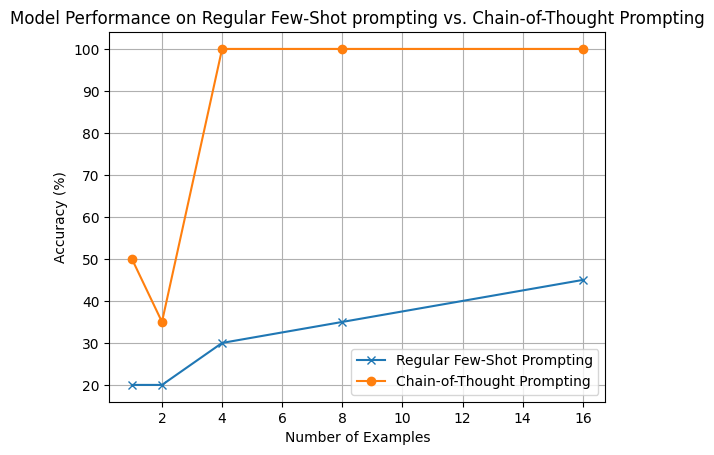

In [ ]:
import matplotlib.pyplot as plt

plt.plot(N_examples, few_shot_results, label = 'Regular Few-Shot Prompting', marker = 'x');
plt.plot(N_examples, CoT_results, label = 'Chain-of-Thought Prompting', marker = 'o');
plt.grid(True);
plt.legend();
plt.xlabel('Number of Examples');
plt.ylabel('Accuracy (%)');
plt.title('Model Performance on Regular Few-Shot prompting vs. Chain-of-Thought Prompting');

Report this table or plot in report.pdf with a short write-up about your observations. Keep the code used to build your table or plot in your notebook for inspection during grading.

Observations:

*   For both prompting methods, accuracy increases when including more examples in the prompt.
*   CoT prompting performs exponentially better than few-shot prompting.
*   Few-shot gradually increases in accuracy as more examples are fed into gpt-3, while CoT increases quickly with more examples.
*   CoT dips in accuracy when going from 1 example to 2 examples (with 2 examples' accuracy being lower than 1 example's accuracy) then quickly increases when using 4 examples. This may be due to the examples I provided in the prompt, but this also shows that not all human-written examples are perfectly processed through gpt-3 even though the examples are written perfectly and that lower example # in a prompt can cause accuracy to also be lower (higher sample sz -> higher accuracy).

*   CoT is able to reach 100% accuracy while few-shot cannot (at least with the number of examples we were testing with).



**Please respond to the following question in your `report.pdf`**

**Problem 5.2 (EXTRA CREDIT):** Your job is to investigate whether or not COT can extend to lengths of words not seen in the chain-of-thought examples.

- Step 1: Try running the original concatenation prompt on a name or phrase with 3 words e.g. 'James Earl Jones' (try running it on at least 4-5 names or phrases). Does it work?
- Step 2: Go back and modify the prompt to get it to work
- Step 3: Now try running this on a name or phrase with 5 words (try running it on at least 4-5 names or phrases). Does it work? If not, how would you extend the prompt to get it to work?

Should you decide to do this exploration, in your report, please include what prompts you tried, at least 3 examples of names you tried the prompts on (3 word and 5 word), and an explanation of why you tried what you tried

Feel free to reference [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/pdf/2201.11903.pdf), especially section 5 on Symbolic Reasoning.

In [ ]:
# TODO (EXTRA CREDIT) Modify the following prompt
MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT = ''''''

In [ ]:
# TODO unit tests


In [ ]:
# TODO (EXTRA CREDIT) Modify the following prompt
MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT = ''''''

In [ ]:
# TODO unit tests


# Submissions

## Submission Checklist (check if you missed anything!)
We will look for the following:
- Section 1:
  - 1.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.3: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.4: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.5: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.6: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
- Section 2:
  - 2.1: Written response in `report.pdf` (Word Limit: 100 words)
  - 2.2: Written response in `report.pdf` and verification of prompt, verbalizers, and number correct
- Section 3:
  - 3.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 3.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 3.3: Written response in `report.pdf`
- Section 4:
  - 4.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 4.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 4.3: Written response in `report.pdf`
- Section 5:
  - 5.1: Written response (table/plot, short-write up) in `report.pdf` and verification of prompt and evaluation function (examples from cell output not required)
  - 5.2: **OPTIONAL**: Written response in `report.pdf` and verification of 2 prompts and 6 unit tests

For the purpose of submission, feel free to complete the entire assignment in the notebook and then convert it into a pdf for the report. However, this is not required as long as all of the deliverables above are satisfied.

**REMINDER**: Include the **expected** answer and the **response** from the OpenAI API in the cell output and `report.pdf` **for all unit tests**.

## GradeScope File Submission

**MAKE SURE TO REMOVE YOUR API KEY FROM YOUR SUBMISSION, YOU WILL LOSE POINTS IF YOUR API KEY IS PRESENT IN THE NOTEBOOK SUBMISSION**

Here are the deliverables you need to submit to GradeScope:
- Write-up (`report.pdf`):
    - All Sections
    - **IMPORTANT**: You will be assigning each page of the report to a question so please make sure you have the correct page(s) assigned to each question, **you will lose 10 points on this assignment if your answers are not assigned correctly**.
- Code:
    - This notebook: make sure it is named `HW4.ipynb` before submitting. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb`